In [ ]:
pip install astropy

Anomalía media (l): 72.03093142128472
Anomalía excéntrica (E): 72.06282679685957
2.97747429315339
9658.409150508365
185.5967106063873


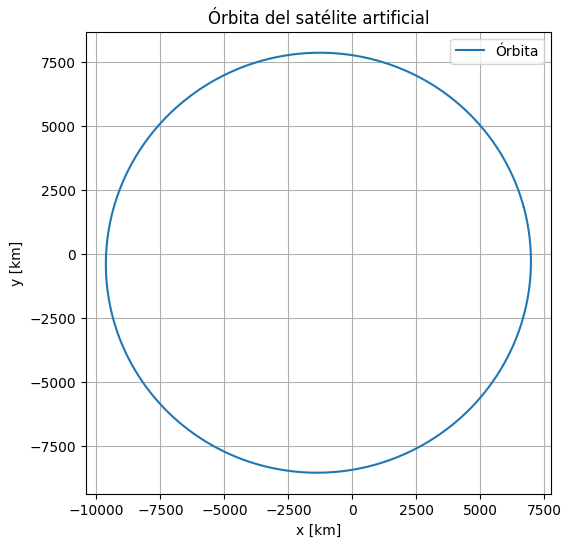

[np.float64(6932.312892590579), np.float64(6932.314453654773), np.float64(6932.319136841001), np.float64(6932.326942130196), np.float64(6932.33786949059), np.float64(6932.351918877702), np.float64(6932.369090234342), np.float64(6932.389383490618), np.float64(6932.412798563925), np.float64(6932.439335358959), np.float64(6932.468993767708), np.float64(6932.501773669457), np.float64(6932.53767493079), np.float64(6932.576697405591), np.float64(6932.618840935044), np.float64(6932.6641053476405), np.float64(6932.71249045917), np.float64(6932.763996072736), np.float64(6932.818621978745), np.float64(6932.876367954921), np.float64(6932.937233766301), np.float64(6933.001219165237), np.float64(6933.068323891399), np.float64(6933.138547671787), np.float64(6933.211890220719), np.float64(6933.288351239847), np.float64(6933.367930418151), np.float64(6933.450627431951), np.float64(6933.536441944904), np.float64(6933.625373608012), np.float64(6933.71742205962), np.float64(6933.812586925431), np.float64

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from astropy.constants import R_earth


# Parámetros físicos y orbitales
GM = 398600.4405  # km^3/s^2
R_earth = R_earth.to('km').value  # km
a = 1.30262 * R_earth
e = 0.16561
omega_deg = 15  # grados
omega = np.radians(omega_deg)

# Tiempo de paso por el pericentro
tp = Time("2025-03-31 00:00:00", format='iso', scale='utc')
t = Time("2025-04-01 00:00:00", format='iso', scale='utc')


def solve_kepler(t, tol=1e-15, max_iter=100):
    delta_t = (t - tp).sec
    n = np.sqrt(GM / a**3)  # frecuencia angular media
    l = n * delta_t         # anomalía media
    E = l if e < 0.2 else np.pi  # valor inicial para E

    for _ in range(max_iter):
        f = E - e * np.sin(E) - l
        df = 1 - e * np.cos(E)
        E_new = E - f / df
        if np.abs(E_new - E) < tol:
            return E_new, l
        E = E_new
    raise RuntimeError("Método de Newton no convergió")



E, l = solve_kepler(t)
print("Anomalía media (l):", l)
print("Anomalía excéntrica (E):", E)
f=2 * np.arctan((np.sqrt(1 + e) * np.sin(E / 2))/(np.sqrt(1 - e) * np.cos(E / 2)))
print(f)
r_t=a * (1 - e**2) / (1 + e * np.cos(f))
print (r_t)
phi=f+omega
phi_degrees=np.degrees(phi)
print(phi_degrees)
def position(t):
    E, _ = solve_kepler(t)
    f = 2 * np.arctan(
        (np.sqrt(1 + e) * np.sin(E / 2)) /
        (np.sqrt(1 - e) * np.cos(E / 2))
    )
    r_t = a * (1 - e**2) / (1 + e * np.cos(f))
    phi = (f + omega) % (2 * np.pi)
    return r_t, phi
r_array = []
t_a = []
def orbit():
    T = 2 * np.pi * np.sqrt(a**3 / GM)
    t_array = np.linspace(0, T, 5000)*u.s
    xa = []
    ya = []

    for dt in t_array:
        t_current = tp + dt
        r_t, phi = position(t_current)
        x = r_t * np.cos(phi)
        y = r_t * np.sin(phi)
        r_array.append(r_t)
        t_a.append(t_current)
        xa.append(x)
        ya.append(y)

    plt.figure(figsize=(6, 6))
    plt.plot(xa, ya, label='Órbita')
    plt.axis('equal')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    plt.title('Órbita del satélite artificial')
    plt.legend()
    plt.grid(True)
    plt.show()
orbit()
print(r_array)

def date(r0):
    # Paso 1: Obtener f (anomalía verdadera) desde r0
    cos_f = (a * (1 - e**2) / r0 - 1) / e
    # Limitar cos_f entre -1 y 1 para evitar errores numéricos
    cos_f = np.clip(cos_f, -1, 1)
    f = np.arccos(cos_f)

    # Paso 2: Obtener E (anomalía excéntrica) desde f
    tan_E2 = np.tan(f / 2) * np.sqrt((1 - e) / (1 + e))
    E = 2 * np.arctan(tan_E2)
    if E < 0:
        E += 2 * np.pi  # asegurar E positivo

    # Paso 3: Calcular l (anomalía media)
    l = E - e * np.sin(E)

    # Paso 4: Calcular t0 desde l
    n = np.sqrt(GM / a**3)
    delta_t = l / n
    t0 = tp + delta_t * u.s

    return t0
r0 = 1.5*R_earth  # puede ser cualquier valor entre pericentro y apocentro

# Llamar a la función para obtener t0
t0 = date(r0)

# Mostrar el resultado
print("t0:", t0.iso)
r01,_=position(t0)
print(r01)
errorr0=r0-r01
print(f"{errorr0:.10f}")